In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import read_minist

train_images = read_minist.read_minist_imgs("minist-data/train-images.idx3-ubyte")
train_labels = read_minist.read_minist_labels("minist-data/train-labels.idx1-ubyte")
print(train_images.shape)
print(train_labels.shape)

(60000, 28, 28)
(60000,)


In [3]:
mean = train_images.mean()/255.0
std = train_images.std()/255.0
print(f"mean: {mean:.4f}, std: {std:.4f}")

mean: 0.1307, std: 0.3081


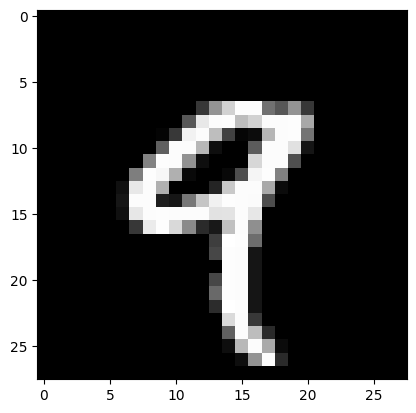

9


In [4]:
plt.imshow(train_images[4], cmap="gray")
plt.show()
print(train_labels[4])

In [5]:
from torch.utils.data import Dataset
from torchvision import transforms

class MyDataset(Dataset):
    def __init__(self, images, labels):
        super(MyDataset, self).__init__()
        self.images = images
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=0.1307, std=0.3081),
        ])

    def __getitem__(self, index):
        image_tensor = self.transform(self.images[index].copy())
        return image_tensor, torch.tensor(self.labels[index])

    def __len__(self):
        return self.images.shape[0]

In [6]:
train_dataset = MyDataset(train_images, train_labels)

In [7]:
class EasyNet(nn.Module):
    def __init__(self):
        super(EasyNet, self).__init__()
        self.conv2d3x3_1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_2 = nn.Linear(in_features=3136, out_features=10)
    def forward(self, x):
        x = self.conv2d3x3_1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = x.flatten(start_dim=1)
        x = self.linear_2(x)
        return x

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = EasyNet().to(device)
input = torch.randn(1, 1, 28, 28)
model = EasyNet().to(device)
output = model(input)
print("output.shape: ", output.shape)
print(model)

device: cpu
output.shape:  torch.Size([1, 10])
EasyNet(
  (conv2d3x3_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_2): Linear(in_features=3136, out_features=10, bias=True)
)


In [9]:
epoches = 30
batch_size = 64
lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [10]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [11]:
from tqdm import tqdm
sample_n = len(train_images)
loss_list = []
acc_list = []
for epoch in range(epoches):
    loss_sum = 0
    acc_sum = 0
    model.train()
    tqdm_train = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epoches}")
    for index, (images, labels) in enumerate(tqdm_train):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        loss = loss.item()
        preds = torch.argmax(logits, dim=1)
        acc = (preds == labels).float().mean().item()
        if index % 100 == 0:
            tqdm_train.set_postfix(loss=loss, accuracy=acc, lr=optimizer.param_groups[0]["lr"])

        loss_sum += loss*images.shape[0]
        acc_sum += acc*images.shape[0]
    scheduler.step()
    loss_epoch = loss_sum/sample_n
    acc_epoch = acc_sum/sample_n
    loss_list.append(loss_epoch)
    acc_list.append(acc_epoch)
    print(f"epoch {epoch+1}/{epoches}, loss: {loss_epoch:.4f}, acc: {acc_epoch:.4f}")


Epoch 1/30: 100%|██████████| 938/938 [00:17<00:00, 54.55it/s, accuracy=0.953, loss=0.124, lr=0.01] 


epoch 1/30, loss: 0.2406, acc: 0.9472


Epoch 2/30: 100%|██████████| 938/938 [00:17<00:00, 53.67it/s, accuracy=0.969, loss=0.223, lr=0.01] 


epoch 2/30, loss: 0.0732, acc: 0.9772


Epoch 3/30: 100%|██████████| 938/938 [00:18<00:00, 51.55it/s, accuracy=0.984, loss=0.0349, lr=0.01]


epoch 3/30, loss: 0.0583, acc: 0.9823


Epoch 4/30: 100%|██████████| 938/938 [00:17<00:00, 52.90it/s, accuracy=0.953, loss=0.0618, lr=0.01]


epoch 4/30, loss: 0.0484, acc: 0.9844


Epoch 5/30: 100%|██████████| 938/938 [00:18<00:00, 49.96it/s, accuracy=1, loss=0.0075, lr=0.01]    


epoch 5/30, loss: 0.0424, acc: 0.9863


Epoch 6/30: 100%|██████████| 938/938 [00:18<00:00, 49.40it/s, accuracy=0.984, loss=0.0701, lr=0.01]


epoch 6/30, loss: 0.0395, acc: 0.9871


Epoch 7/30: 100%|██████████| 938/938 [00:17<00:00, 52.77it/s, accuracy=0.984, loss=0.0983, lr=0.01]


epoch 7/30, loss: 0.0368, acc: 0.9879


Epoch 8/30: 100%|██████████| 938/938 [00:17<00:00, 52.84it/s, accuracy=0.969, loss=0.0757, lr=0.01]


epoch 8/30, loss: 0.0305, acc: 0.9900


Epoch 9/30: 100%|██████████| 938/938 [00:18<00:00, 51.22it/s, accuracy=1, loss=0.00221, lr=0.01]   


epoch 9/30, loss: 0.0275, acc: 0.9908


Epoch 10/30: 100%|██████████| 938/938 [00:17<00:00, 52.98it/s, accuracy=1, loss=2.6e-5, lr=0.01]    


epoch 10/30, loss: 0.0277, acc: 0.9908


Epoch 11/30: 100%|██████████| 938/938 [00:17<00:00, 52.86it/s, accuracy=0.984, loss=0.0142, lr=0.001]


epoch 11/30, loss: 0.0090, acc: 0.9972


Epoch 12/30: 100%|██████████| 938/938 [00:18<00:00, 50.99it/s, accuracy=1, loss=0.000169, lr=0.001]  


epoch 12/30, loss: 0.0046, acc: 0.9987


Epoch 13/30: 100%|██████████| 938/938 [00:17<00:00, 52.26it/s, accuracy=1, loss=0.000115, lr=0.001]  


epoch 13/30, loss: 0.0030, acc: 0.9995


Epoch 14/30: 100%|██████████| 938/938 [00:18<00:00, 52.03it/s, accuracy=1, loss=3.04e-5, lr=0.001] 


epoch 14/30, loss: 0.0023, acc: 0.9996


Epoch 15/30: 100%|██████████| 938/938 [00:19<00:00, 47.99it/s, accuracy=1, loss=0.00128, lr=0.001] 


epoch 15/30, loss: 0.0016, acc: 0.9998


Epoch 16/30: 100%|██████████| 938/938 [00:20<00:00, 45.58it/s, accuracy=1, loss=0.00133, lr=0.001] 


epoch 16/30, loss: 0.0012, acc: 0.9999


Epoch 17/30: 100%|██████████| 938/938 [00:18<00:00, 51.47it/s, accuracy=1, loss=0.00136, lr=0.001] 


epoch 17/30, loss: 0.0010, acc: 0.9999


Epoch 18/30: 100%|██████████| 938/938 [00:18<00:00, 51.57it/s, accuracy=1, loss=0.00149, lr=0.001] 


epoch 18/30, loss: 0.0007, acc: 0.9999


Epoch 19/30: 100%|██████████| 938/938 [00:19<00:00, 49.13it/s, accuracy=1, loss=0.000126, lr=0.001]


epoch 19/30, loss: 0.0005, acc: 1.0000


Epoch 20/30: 100%|██████████| 938/938 [00:18<00:00, 49.48it/s, accuracy=1, loss=0.000169, lr=0.001]


epoch 20/30, loss: 0.0003, acc: 1.0000


Epoch 21/30: 100%|██████████| 938/938 [00:18<00:00, 49.86it/s, accuracy=1, loss=0.000828, lr=0.0001]


epoch 21/30, loss: 0.0003, acc: 1.0000


Epoch 22/30: 100%|██████████| 938/938 [00:19<00:00, 47.60it/s, accuracy=1, loss=0.000154, lr=0.0001]


epoch 22/30, loss: 0.0002, acc: 1.0000


Epoch 23/30: 100%|██████████| 938/938 [00:19<00:00, 48.68it/s, accuracy=1, loss=3.84e-5, lr=0.0001] 


epoch 23/30, loss: 0.0002, acc: 1.0000


Epoch 24/30: 100%|██████████| 938/938 [00:18<00:00, 52.07it/s, accuracy=1, loss=2.93e-5, lr=0.0001] 


epoch 24/30, loss: 0.0002, acc: 1.0000


Epoch 25/30: 100%|██████████| 938/938 [00:19<00:00, 48.43it/s, accuracy=1, loss=3.73e-7, lr=0.0001] 


epoch 25/30, loss: 0.0001, acc: 1.0000


Epoch 26/30: 100%|██████████| 938/938 [00:18<00:00, 51.15it/s, accuracy=1, loss=4.13e-5, lr=0.0001] 


epoch 26/30, loss: 0.0001, acc: 1.0000


Epoch 27/30: 100%|██████████| 938/938 [00:19<00:00, 49.23it/s, accuracy=1, loss=2.17e-5, lr=0.0001] 


epoch 27/30, loss: 0.0001, acc: 1.0000


Epoch 28/30: 100%|██████████| 938/938 [00:19<00:00, 47.90it/s, accuracy=1, loss=3.95e-5, lr=0.0001] 


epoch 28/30, loss: 0.0001, acc: 1.0000


Epoch 29/30: 100%|██████████| 938/938 [00:18<00:00, 49.86it/s, accuracy=1, loss=0.000133, lr=0.0001]


epoch 29/30, loss: 0.0001, acc: 1.0000


Epoch 30/30: 100%|██████████| 938/938 [00:18<00:00, 50.12it/s, accuracy=1, loss=0.000215, lr=0.0001]

epoch 30/30, loss: 0.0001, acc: 1.0000


In [12]:
torch.save(model.state_dict(), "model.pth")
print("model saved")

model saved


In [13]:
epoches_list = [i for i in range(1, epoches+1)]

plt.figure()
plt.plot(epoches_list, loss_list)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("loss")
plt.savefig("loss.png")
#plt.show()
plt.close()

plt.figure()
plt.plot(epoches_list, acc_list)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("accuracy")
plt.savefig("accuracy.png")
#plt.show()
plt.close()

In [14]:
model_test = EasyNet()
model_test.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [15]:
test_images = read_minist.read_minist_imgs("minist-data/t10k-images.idx3-ubyte")
test_labels = read_minist.read_minist_labels("minist-data/t10k-labels.idx1-ubyte")

index_rand:  313


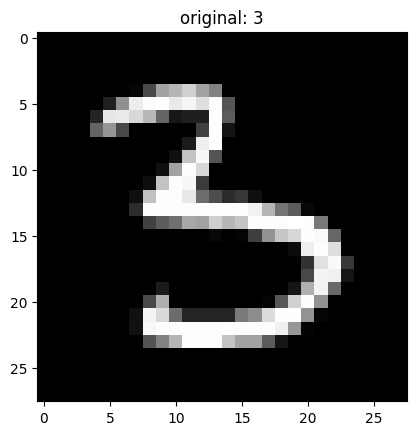

pred: 3


In [92]:
import random
from matplotlib import pyplot as plt
index_rand = random.randint(0, len(test_images) - 1)
print("index_rand: ", index_rand)
test_image = test_images[index_rand]
test_label = test_labels[index_rand]
test_dataset = MyDataset(test_images, test_labels)
test_image_tensor, _ = test_dataset[index_rand]
test_image_tensor = test_image_tensor.unsqueeze(0)
logits = model_test(test_image_tensor)
pred = torch.argmax(logits, dim=1).item()

plt.figure()
plt.imshow(test_image, cmap="gray")
plt.title(f"original: {test_label}")
plt.show()
print(f"pred: {pred}")